### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from tqdm import tqdm_notebook as tqdm

### Code

In [3]:
def check_accuracy():
    divide_by_me = [34.74545454545454, 29.542028985507248, 12.324062877871826, 
             11.278495020287716, 18.092307692307692, 23.61081081081081, 
             47.18518518518518, 14.422641509433962, 12.787954830614806,
             16.689956331877728, 22.75, 19.984313725490196, 
             13.105872267466781, 26.40414507772021, 19.841661258922777, 
             11.985887887103097, 21.0, 19.351898734177215]
    log_preds, y = learn.TTA()
    preds = np.exp(log_preds)
    probs = np.mean(preds, 0)
        
    thresholded_probs = [np.divide(prob, divide_by_me) for prob in probs]
    print('acc:', accuracy_np(probs, y))
    print('acc with thresholding:', accuracy_np(thresholded_probs, y))

In [4]:
PATH='data/'
sz = 224

In [5]:
arch=resnext50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [18]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=4, test_name='test')

### Training the last layer

In [21]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [8]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

/Users/alex/Git_Files/shopee_com/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


In [19]:
! open .

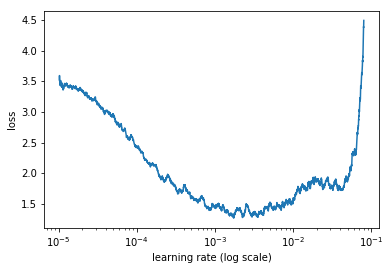

In [9]:
learn.sched.plot()

In [12]:
lr = 1e-3
prefix = 'full-'
last_layer_save_name = prefix + 'resnext50-last'
last_layer_best_save_name = prefix + 'resnext50-last-best'

In [11]:
#8 epochs might be good
learn.fit(lr, 20, 
          cycle_save_name=last_layer_save_name, 
          best_save_name=last_layer_best_save_name)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

/Users/alex/Git_Files/shopee_com/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/alex/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/alex/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/alex/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      1.057061   0.820893   0.722906  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    1      0.992372   0.776044   0.731021  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    2      0.915731   0.757875   0.736257  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    3      0.910762   0.753799   0.734948  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    4      0.806279   0.740208   0.745026  



[0.7402076, 0.7450262]

In [17]:
suffix=5
learn.load(last_layer_best_save_name+suffix)

In [22]:
learn.precompute=False

In [19]:
learn.fit(lr, 6, cycle_len=1, cycle_save_name=last_layer_save_name, best_save_name=last_layer_best_save_name)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

/Users/alex/Git_Files/shopee_com/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


epoch      trn_loss   val_loss   accuracy   
    0      0.893058   0.673474   0.765314  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    1      0.839789   0.671936   0.766885  


HBox(children=(IntProgress(value=0, max=6100), HTML(value='')))

    2      0.8347     0.670388   0.766361  



[0.6703879, 0.76636124]

In [22]:
learn.load(last_layer_best_save_name)

In [23]:
check_accuracy()

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

acc: 0.7829447209850668
acc with thresholding: 0.7746921666230023


### Fine tuning on all weights

In [23]:
learn.unfreeze()
#learn.save(prefix + 'resnext50-last_layer_done')

In [13]:
lr = [1e-5, 1e-4, 1e-3]
ft_name = prefix + 'resnext50-ft'
ft_best_name = f'{ft_name}-best'
#learn.fit(lr, 5, cycle_len=1, cycle_mult=2,
#          cycle_save_name=ft_name,
#          best_save_name=ft_best_name)

In [24]:
learn.load(ft_best_name)
check_accuracy()

# Submitting to Kaggle

In [25]:
t_log_preds, y = learn.TTA(is_test=True)
probs = np.exp(t_log_preds)
probs = np.mean(probs, 0)
cats = np.argmax(probs, 1)
print(cats.shape)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/alex/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/alex/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/alex/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



NameError: name 'log_preds' is not defined

In [33]:
ds = pd.DataFrame(cats)
ds.columns = ['category']
ds.insert(0, 'id', [o[10:-4] for o in data.test_ds.fnames])
ds.head()

,id,category
0,11690,14
1,9837,12
2,11848,12
3,13087,5
4,14930,4


In [35]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [37]:
#FileLink(f'{SUBM}subm.gz')
! open .

###  Analyzing results

In [25]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [26]:
print(probs.shape)
probs[0]

(7634, 18)


array([0.99997, 0.     , 0.     , 0.     , 0.     , 0.00001, 0.00001, 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ], dtype=float32)

In [58]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[634   6   0  11   3   0   3   0   2   4   4   0   0   0   0   0   1   9]
 [ 11 496   1   3   0   0   1   0   0   1   8   0   0   0   2   2   0   4]
 [  5   6 344  10   3   0   0   5   0   2   1   1   0   0   2   1   4   1]
 [  7   2   3 295  11  20   1   6   1   5   1  21   0   2   0   5   0   2]
 [  3   0   0  12 367   4   0   0   0   1   0   2   0   0   0   0   3   2]
 [  1   1   0  23   1 249   1  56   0  17   0   7   0  38   0  12  16   0]
 [  0   0   0   0   0   0 480   1   3   1 122   0  11   0   2   0   0   0]
 [  0   0   2   7   2  24   1 504   2  17   0  24   0  12   0  34   7   1]
 [  1   0   1   0   1   0   1   0 221   0  17   0  11   0  36   0   0   0]
 [  0   1   0   2   0   6   0  15   2 371   0  42   0   4   1   8   5   0]
 [  1   0   0   0   0   0  55   0  29   1 463   0  24   0  24   0   0   0]
 [  0   3   0  10   0   9   1  56   0  81   1 357   0  37   1   7  20   0]
 [  0   0   1   0   0   0   5   0  27   0  41   0 275   0  15   0   0   0]
 [  0   0   0   1   0  48

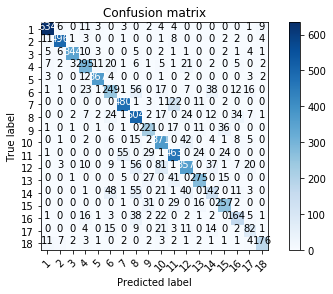

In [63]:
plot_confusion_matrix(cm, (range(1,19)))

In [ ]:
print('Bad categories')
print(data.classes[11], data.classes[7])
print(data.classes[12], data.classes[10])
print(data.classes[9], data.classes[15])
print(data.classes[6], data.classes[8])

In [71]:
lowest_probs_ranked = np.argsort(probs)
print(lowest_probs_ranked)

[1475 1504 4155 ...  700 1185 1108]
7.898994e-12
1.0


In [72]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds==data.val_y)==is_correct)
def load_img_id(ds, idx): return PIL.Image.open(PATH+ds.fnames[idx])
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

worst failures
[2 2 8 8 8 8 8 8 8 2]
[2 2 8 8 8 8 8 8 8 2]
['BabyBibs', 'BabyHat', 'BabyPants', 'BabyShirt', 'PackageFart', 'womanshirtsleeve', 'womencasualshoes', 'womenchiffontop', 'womendollshoes', 'womenknittedtop', 'womenlazyshoes', 'womenlongsleevetop', 'womenpeashoes', 'womenplussizedtop', 'womenpointedflatshoes', 'womensleevelesstop', 'womenstripedtop', 'wrapsnslings']
[1475 1504 4155 4240 4208 4124 4182 4184 4334 1306]


'\ndef most_by_mask(mask, mult):\n    idxs = np.where(mask)[0]\n    return idxs[np.argsort(mult * probs[idxs])[:4]]\ndef most_by_correct(y, is_correct):\n    mult = -1 if (y==1)==is_correct else 1\n    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y==y), mult)\n'

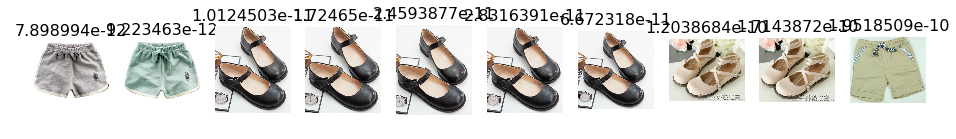

In [79]:
plot_val_with_title(lowest_probs_ranked[:10], 'worst failures')
print(y[lowest_probs_ranked[:10]])
print(preds[lowest_probs_ranked[:10]])
print(data.classes)
print(lowest_probs_ranked[:10])
'''
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y==y), mult)
'''

In [80]:
!open .

### Extensions

In [ ]:
'''
3) add some dropout (do we train from scratch?, i think so..)
3) try resnext 
4) try all data
'''
'''
!) Add more transforms
2) try super resolution 
'''